# DRACS Tutorial

This tutorial demonstrates how to use DRACS (Dynamic Representation of Argument Construction Style) on preprocessed AIF (Argument Interchange Format) data.


Overview
We will cover the following steps:

1. Input Data Format — what your preprocessed AIF should look like.
2. Running DRACS — how to run the feature extraction.
3. Output Format — what kind of features DRACS produces.
4. Customization: how to add or remove features from DRACS.

In [31]:
# Add the DRACS code directory (adjust the path as needed)

dracs_root_dir = "../"  # Replace with the full path if necessary

import sys
sys.path.append(dracs_root_dir)

## Loading data

DRACS works on AIF files that are already preprocessed into an intermediate format.

The `data` directory contains datasets from the paper as references.

In [32]:
import json, os

filepath = "US2016G1tv/nodeset10701.json"

aif_data = json.load(
    open(
        os.path.join(dracs_root_dir, "data/US2016G1tv/nodeset10701.json"),'r'
    )
)

In [33]:
aif_data.keys()

dict_keys(['nodes', 'edges', 'locutions', 'meta'])

In [4]:
aif_data

{'nodes': [{'nodeID': '242653',
   'text': 'Mr. Trump , could we just take 10 seconds and then we ask the final question',
   'type': 'I',
   'timestamp': '2016-11-11 13:24:54',
   'text_occ_idx': 0},
  {'nodeID': '242655',
   'text': 'HOLT : Mr. Trump , could we just take 10 seconds and then we ask the final question',
   'type': 'L',
   'timestamp': '2016-11-11 13:24:55',
   'text_occ_idx': 0},
  {'nodeID': '242658',
   'text': 'TRUMP : Hillary is hitting me with tremendous commercials',
   'type': 'L',
   'timestamp': '2016-11-11 13:24:55',
   'text_occ_idx': 106},
  {'nodeID': '242660',
   'text': 'CLINTON is hitting TRUMP with tremendous commercials',
   'type': 'I',
   'timestamp': '2016-11-11 13:24:55',
   'text_occ_idx': 106},
  {'nodeID': '242663',
   'text': "TRUMP : Some of it 's said in entertainment",
   'type': 'L',
   'timestamp': '2016-11-11 13:24:56',
   'text_occ_idx': 158},
  {'nodeID': '242665',
   'text': "some of it 's said in entertainment",
   'type': 'I',
   't

Note that DRACS require a special key in I nodes "text_occ_idx"

text_occ_idx is int values that indicates, when the text from I-node happened in the argument chronologically. For example, I-node with text_occ_idx 0 was mentioned before the I-node with text_occ_idx 10.


In [5]:
aif_data_i_nodes = [node_dict for node_dict in aif_data['nodes'] if node_dict['type'] == 'I']
aif_data_i_nodes[0]

{'nodeID': '242653',
 'text': 'Mr. Trump , could we just take 10 seconds and then we ask the final question',
 'type': 'I',
 'timestamp': '2016-11-11 13:24:54',
 'text_occ_idx': 0}

In [6]:
len(aif_data_i_nodes)

9

## Run DRACS Feature Extraction

Use the `extract_dracs_features` function to extract construction style features from AIF graph.

In [34]:
from feature_extraction import AIFTimeChunkSplitter, AIFTimeFillingFeatureExtractor

In [35]:
dracs_features, feature_names = AIFTimeChunkSplitter.get_time_features(
    aif=aif_data, 
    aif_method='binary', # AIF representation as adjacency matrix.
    remove_node_types=["TA", "L"], # remove L and TA part. YA nodes attached to them will be removed automatically.
    verbose=False
)

In [9]:
type(dracs_features), dracs_features.shape, len(feature_names)

(numpy.ndarray, (9, 14), 14)

In [10]:
feature_names

['Density',
 'AVG In-Degree',
 'AVG Out-Degree',
 'AVG Degree',
 'MAX In-Degree',
 'MAX Out-Degree',
 'LAST NODE In-Degree',
 'LAST NODE Out-Degree',
 'LEN/NODES Longest Path',
 'Core AVG Num',
 'N Leafs I',
 'Num W Comps',
 'AVG Len W Comps',
 'N Isolated I']

## Visualize Features

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def generate_colors(n, cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    return [cmap(i % cmap.N) for i in range(n)]
    
def plot_time_series(series, 
                     names=None,
                     labels=(), 
                     height_ax=1,
                     width=10,
                     keep_feature_ids=None, 
                     savepath=None
                    ):
    
    dims = [[x for x in zip(*s)] for s in series]

    total_dims = len(dims[0])
    if not names:
        names = [f"Dim {i}" for i in range(total_dims)]
    if keep_feature_ids is None:
        keep_feature_ids = list(range(total_dims))

    colors = generate_colors(len(dims))
    n_feats = len(keep_feature_ids)
    ncols = 2
    nrows = (n_feats + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(width, nrows * height_ax), sharex=True)
    axes = axes.flatten()
    fig.tight_layout(pad=2.0)

    for ax_idx, feat_idx in enumerate(keep_feature_ids):
        ax = axes[ax_idx]
        for j, d in enumerate(dims):
            ax.plot(d[feat_idx], label=labels[j], color=colors[j], linestyle='-', marker=None)
        ax.set_title(names[feat_idx], fontsize=10)
        ax.set_ylabel('Value', fontsize=8)
        ax.tick_params(labelsize=8)
        ax.legend(fontsize=7, loc='upper right')

    # Hide any unused subplots
    for ax in axes[n_feats:]:
        ax.axis('off')

    # Label bottom row's x-axes
    for ax in axes[-ncols:]:
        ax.set_xlabel('Time', fontsize=9)
    plt.show()

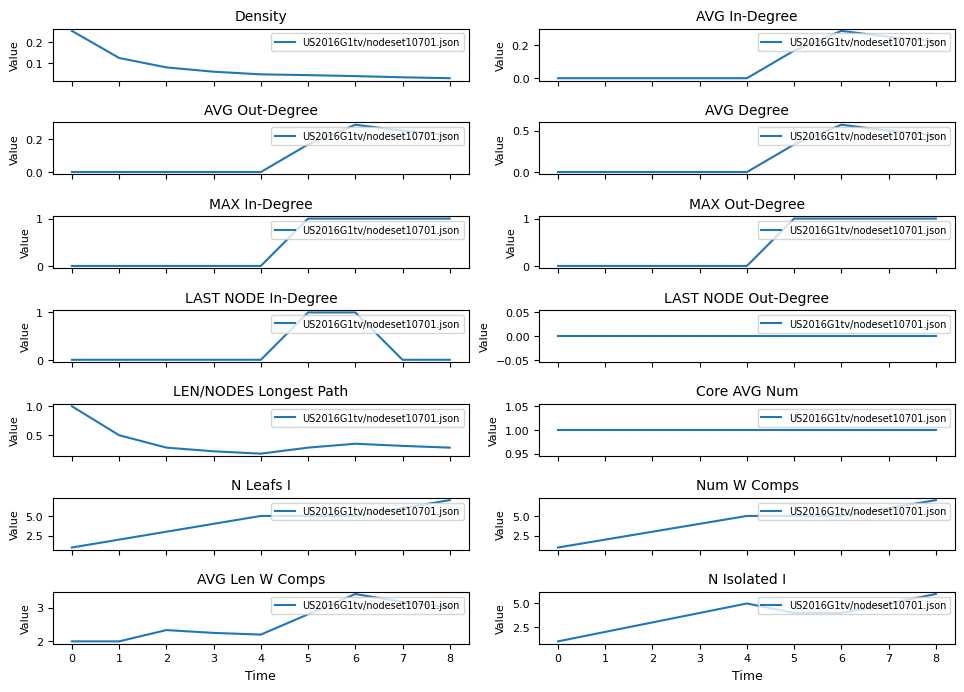

In [12]:
plot_time_series(
    series=[dracs_features],
    names=feature_names,
    labels=[filepath], 
    keep_feature_ids=None
)

## Customize DRACS

You can remove or add feature extractors into DRACS easily. In this example, we will add new dimensions in the extract features:

- Dummy 0.
- Average of all previous densities.

In [24]:
# Add dummy-always-0 feature

from feature_extraction import AIFTimeFillingFeatureExtractor
class ExtendedAIFTimeFillingFeatureExtractor(AIFTimeFillingFeatureExtractor):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.vector_dims_features.append(self.dummy_zero_feature)

    def dummy_zero_feature(self, vectors_history, **kwargs):
        features = [0]
        features_names = ['Dummy 0']

        return features, features_names

# 🔍 Understanding the Feature Extractor Code

Let's break down what the code is doing:

---

## 1. Adding a New Feature Method: `dummy_zero_feature`

We define a new method in the class called `dummy_zero_feature`. Every feature extraction method **must** accept the following three arguments:

* **`vectors_history`**: A list of NumPy arrays, each of shape `(num_features,)`.
  These represent the features extracted at **previous steps only** — the current step is **not included**.

* **`previous_aifs`**: A list of `GraphAIF` objects (one per step).
  This list includes **all AIFs up to and including the current step**.

* **`previous_nx_graphs`**: A list of `networkx.DiGraph` objects, also one per step.
  Again, this includes **all graphs up to and including the current step**.

📌 **Example:**
If we are currently extracting features at **step 10**, then:

* `vectors_history` will have **9 entries** (steps 0 to 8)
* `previous_aifs` and `previous_nx_graphs` will each have **10 entries** (steps 0 to 9)

---

#### 2. Expected Output Format

Each feature extraction method should return a **tuple** containing:

* A **list of numerical features** (e.g., `[0.0, 1.2, 3.5]`)
* A **list of feature names** (e.g., `["bias_score", "depth", "length"]`)
  📌 These must match in **length and order** with the numerical features.

---

#### 3. Registering the Feature Function

To enable DRACS to use the new feature method, you must register it during class initialization (`__init__`) by appending it to the internal list:

```python
self.vector_dims_features.append(self.dummy_zero_feature)
```

This tells the extractor to call `dummy_zero_feature` at every step during feature computation.

In [36]:
# Add rolling average of densities 

from feature_extraction import AIFTimeFillingFeatureExtractor
class ExtendedAIFTimeFillingFeatureExtractor(AIFTimeFillingFeatureExtractor):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # default order of feature extractions
        self.vector_dims_features = [
            self.edges_stats_dims, # Here is the first feature is Density
            self.nodes_degrees_stats_dim,
            self.path_stats_dims,
            self.core_stats_dims,
            self.num_leafs_stats_dims,
            self.connected_components_stats_dims,
            self.isolated_i_nodes_stats_dims,
        ]

        self.vector_dims_features.append(self.dummy_zero_feature)
        self.vector_dims_features.append(self.rolling_density_mean) # add rolling_density_mean to processor

    def dummy_zero_feature(self, vectors_history, **kwargs):
        features = [0]
        features_names = ['Dummy 0']

        return features, features_names

    def rolling_density_mean(self, vectors_history, **kwargs):
        roll_avg = sum([features[0] for features in vectors_history])/len(vectors_history) if len(vectors_history) else 0.0

        features = [roll_avg]
        features_names = ['Rolling AVG Density']

        return features, features_names

## Adding Rolling Density Average
---
The idea is the same, but `rolling_density_mean` extracted features from before and averaged them. 

In [28]:
# Running with extended feature extractor

dracs_features, feature_names = AIFTimeChunkSplitter.get_time_features(
    aif=aif_data, 
    aif_method='binary', 
    remove_node_types=["TA", "L"],
    verbose=False,
    feature_extractor=ExtendedAIFTimeFillingFeatureExtractor
)

In [29]:
dracs_features.shape, len(feature_names)

((9, 16), 16)

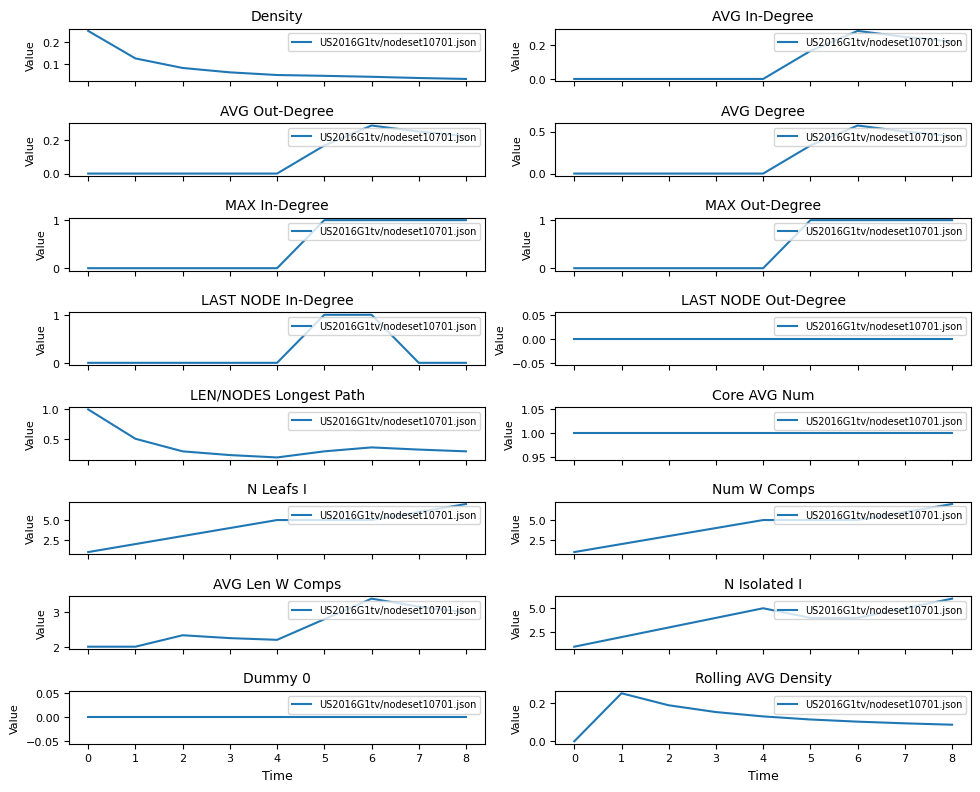

In [30]:
plot_time_series(
    series=[dracs_features],
    names=feature_names,
    labels=[filepath], 
    keep_feature_ids=None
)